In [70]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors
import pandas as pd
import haversine as hs
import geopandas as gp
from shapely.geometry import Point, Polygon
import numpy as np

from pyomo.environ import Var, Expression, NonNegativeReals, Block, ConcreteModel, Constraint, Objective, Param, maximize, SolverFactory,RangeSet
import pyomo.environ as pyo
from idaes.core import FlowsheetBlock
from pyomo.environ import Block, Expression, units as pyunits
import math
from watertap3.utils import watertap_setup, get_case_study, run_model 
from watertap3.utils import run_watertap3, run_model_no_print, run_and_return_model
# from truck_pipe_cost_functions import truck_costing, pipe_costing

from IPython.display import clear_output

In [71]:
# Inputs for analysis
# State abbreviation and code to map all relevant files
state_code = pd.read_csv(r'\Users\mhardika\Documents\AMO\2050\analysis_files\state_geocode.csv')

# State shape file
us_states = gp.read_file(r'C:\Users\mhardika\Documents\AMO\2050\analysis_files\tl_rd22_us_state\tl_rd22_us_state.shp')

# Counties shape files
us_counties = gp.read_file(r'\Users\mhardika\Documents\AMO\GeoToolAll_Methods\GeoData\US_County_Boundaries\US_CountyBndrys.shp')
us_counties = us_counties.to_crs("EPSG:4326")

# USGS present municipal demand
# demand_present_df = pd.read_csv(r'\Users\mhardika\Documents\AMO\GeoToolAll_Methods\Water Source Data\Domestic\USGS_domestic_metric.csv')
demand_present_df = pd.read_csv(r'\Users\mhardika\Documents\AMO\2050\analysis_files\water_demand.csv')

# USDA demand projections assuming same fraction of demand is being met surface and ground even in 2050
demand_projection_df = pd.read_csv(r'\Users\mhardika\Documents\AMO\2050\analysis_files\water_demand_projections_usda_baseline.csv')

# Population in 2020 and 2050
pop_df = pd.read_csv(r'\Users\mhardika\Documents\AMO\2050\analysis_files\pop_projection.csv')
pop_df = pop_df[~(pop_df == 0).any(axis=1)].reset_index(drop=True)
# Treatment facilities - not using this anymore. Instead looking at usgs fraction of surface and ground water
# treatment_df = pd.read_csv(r'\Users\mhardika\Documents\AMO\2050\analysis_files\treatment_facilities_analysis.csv')
# treatment_df = treatment_df.drop_duplicates('name',ignore_index = True)

# CO2 emissions
co2_df = pd.read_csv(r'\Users\mhardika\Documents\AMO\2050\analysis_files\co2_emissions.csv')
co2_df = co2_df.set_index(['state'])

In [72]:
# Functions to calculate energy intensity based on scenario
treatment_energy_baseline_dict = {'SW': 0.107, 'GW': 0.102,  'BW':0.57,'Desal':3.03,'PR': 1.634}
add_treatment = {'yes': (5125+9)/3785.4118, 'no': 0}
distribution_energy = {'low': 50/3785.4118, 'medium':525/3785.4118, 'high': 1000/3785.4118} 
pumping_energy = {'SW': 0.0383, 'GW': 0.13916, 'BW': 0.307,'Desal': 0.1023, 'PR': 0.0383}

Data for waterfall sensitivity

In [73]:
# Baseline
analysis_results_2050 = pd.read_csv(r'\Users\mhardika\Documents\AMO\2050\analysis_files\analysis_2050.csv').drop(columns=['Unnamed: 0'])
analysis_results_2050.head(2)

,state,state_id,county_id,county,geoid,pop_2050,county_demand_2050(m3/day),county_demand_per_capita_2050(m3/day),sw_frac,gw_frac,bw_frac,desal_frac,pr_frac,treatment_pumping_energy(kwh/m3),dist_energy(kwh/m3),total_energy(mwh/year),co2(kg/year)
0,NE,31,39,Cuming,31039,9782.697821,4370.176538,0.446725,0.0,0.999997,0,0,0,0.241159,0.13869,606.318726,9943.627112
1,NE,31,109,Lancaster,31109,483102.517000,122380.810700,0.253323,0.0,0.999997,0,0,0,0.241159,0.13869,16979.125815,278457.663361


In [74]:
# Sensitivity analysis table

sensitivity_results = pd.DataFrame()

# Removing US territories and AK, HI
us_counties_temp = us_counties[(us_counties['STATEFP']!='78') & (us_counties['STATEFP']!='69') &
                            (us_counties['STATEFP']!='66') & (us_counties['STATEFP']!='60') & (us_counties['STATEFP']!='72')
                            & (us_counties['STATEFP']!='02') & (us_counties['STATEFP']!='15')]

geoid_list = []
state_id_list = []
county_id_list = []
county_list = []
state_list = []
state_id_list = []
low_pop_list = []
pop_list = []
high_pop_list = []

ssp2_wet_demand_list = []
ssp2_hot_demand_list = []

ssp2_norm_demand_list = []
ssp3_norm_demand_list = []
ssp5_norm_demand_list = []

ssp5_wet_demand_list = []
ssp5_hot_demand_list = []

treatment_type_list = []
geometry = []
idx_list = []

state_code_temp = state_code.set_index('state_id')
pop_df_temp = pop_df.set_index('geoid')
demand_projection_df_temp = demand_projection_df.set_index('geoid')

# Going state wise
for state_id in us_counties_temp['STATEFP'].unique():
    state = state_code_temp.loc[int(state_id)]['abbv']
    state_df = us_counties_temp[us_counties_temp['STATEFP']==state_id]
    # Iterate through rows of us_counties
    for idx, row in state_df.iterrows():
        county = row['NAME']
        geoid = int(row['GEOID'])
        
        try:
            demand = demand_projection_df_temp.loc[geoid]
            ssp2_wet_demand_list.append(demand['2050_ssp2_wet_domestic_supply_total(m3/day)'])
            ssp2_hot_demand_list.append(demand['2050_ssp2_hot_domestic_supply_total(m3/day)'])
            ssp2_norm_demand_list.append(demand['2050_ssp2_norm_domestic_supply_total(m3/day)'])

            ssp3_norm_demand_list.append(demand['2050_ssp3_norm_domestic_supply_total(m3/day)'])
            ssp5_norm_demand_list.append(demand['2050_ssp5_norm_domestic_supply_total(m3/day)'])

            ssp5_wet_demand_list.append(demand['2050_ssp5_wet_domestic_supply_total(m3/day)'])
            ssp5_hot_demand_list.append(demand['2050_ssp5_hot_domestic_supply_total(m3/day)'])
            
            state_list.append(state)
            state_id_list.append(int(state_id))
            county_list.append(county)
            county_id_list.append(row['COUNTYFP'])
            geoid_list.append(geoid)
            pop = pop_df_temp.loc[geoid]
            low_pop_list.append(pop['ssp32050'])
            pop_list.append(pop['ssp22050'])
            high_pop_list.append(pop['ssp52050'])
        except:
            idx_list.append(idx)


us_counties_temp = us_counties_temp.drop(index = idx_list)
sensitivity_results['state'] = state_list
sensitivity_results['state_id'] = state_id_list 
sensitivity_results['county_id'] = county_id_list 
sensitivity_results['county'] = county_list
sensitivity_results['geoid'] = geoid_list
sensitivity_results['geometry'] = us_counties_temp['geometry']

sensitivity_results['ssp2_wet_demand(m3/day)'] = ssp2_wet_demand_list
sensitivity_results['ssp2_hot_demand(m3/day)'] = ssp2_hot_demand_list
sensitivity_results['ssp2_norm_demand(m3/day)'] = ssp2_norm_demand_list

sensitivity_results['ssp3_norm_demand(m3/day)'] = ssp3_norm_demand_list
sensitivity_results['ssp5_norm_demand(m3/day)'] = ssp5_norm_demand_list

sensitivity_results['ssp5_wet_demand(m3/day)'] = ssp5_wet_demand_list
sensitivity_results['ssp5_hot_demand(m3/day)'] = ssp5_hot_demand_list

sensitivity_results['pop_low'] = low_pop_list
sensitivity_results['pop_high'] = high_pop_list
sensitivity_results['pop'] = pop_list

sensitivity_results['treatment_energy(kwh/m3)'] = analysis_results_2050['sw_frac']*(treatment_energy_baseline_dict['SW'])\
                                                + analysis_results_2050['gw_frac']*(treatment_energy_baseline_dict['GW']) \
                                                + analysis_results_2050['bw_frac']*(treatment_energy_baseline_dict['BW']) \
                                                + analysis_results_2050['desal_frac']*(treatment_energy_baseline_dict['Desal'])\
                                                + analysis_results_2050['pr_frac']*(treatment_energy_baseline_dict['PR'])

sensitivity_results['low_treatment_energy(kwh/m3)'] = analysis_results_2050['sw_frac']*(treatment_energy_baseline_dict['SW']*0.8)\
                                                + analysis_results_2050['gw_frac']*(treatment_energy_baseline_dict['GW']*0.8) \
                                                + analysis_results_2050['bw_frac']*(treatment_energy_baseline_dict['BW']*0.8 ) \
                                                + analysis_results_2050['desal_frac']*(treatment_energy_baseline_dict['Desal']*0.8 )\
                                                + analysis_results_2050['pr_frac']*(treatment_energy_baseline_dict['PR']*0.8)


sensitivity_results['high_treatment_energy(kwh/m3)'] = analysis_results_2050['sw_frac']*(treatment_energy_baseline_dict['SW']/0.5 )\
                                                + analysis_results_2050['gw_frac']*(treatment_energy_baseline_dict['GW']/0.5 ) \
                                                + analysis_results_2050['bw_frac']*(treatment_energy_baseline_dict['BW']/0.5 ) \
                                                + analysis_results_2050['desal_frac']*(treatment_energy_baseline_dict['Desal']/0.5 )\
                                                + analysis_results_2050['pr_frac']*(treatment_energy_baseline_dict['PR']/0.5 )

sensitivity_results['pumping_energy(kwh/m3)'] = analysis_results_2050['sw_frac']*(pumping_energy['SW'])\
                                                + analysis_results_2050['gw_frac']*(pumping_energy['GW']) \
                                                + analysis_results_2050['bw_frac']*(pumping_energy['BW']) \
                                                + analysis_results_2050['desal_frac']*(pumping_energy['Desal'])\
                                                + analysis_results_2050['pr_frac']*(pumping_energy['PR'])

sensitivity_results.loc[:,'dist_energy(kwh/m3)'] = distribution_energy['medium']
sensitivity_results.loc[:,'low_dist_energy(kwh/m3)'] = distribution_energy['low']
sensitivity_results.loc[:,'high_dist_energy(kwh/m3)'] = distribution_energy['high']

sensitivity_results['total_energy(kwh/m3)'] = (sensitivity_results['treatment_energy(kwh/m3)'] + sensitivity_results['pumping_energy(kwh/m3)']\
                                                 + sensitivity_results['dist_energy(kwh/m3)'])

sensitivity_results['co2_low'] = analysis_results_2050['total_energy(mwh/year)']*[co2_df.loc[state]['2050_low (kg/MWh)'] for state in state_list] 
sensitivity_results['co2_high'] = analysis_results_2050['total_energy(mwh/year)']*[co2_df.loc[state]['2050_high (kg/MWh)'] for state in state_list] 


In [75]:
sensitivity_results.head(2)

,state,state_id,county_id,county,geoid,geometry,ssp2_wet_demand(m3/day),ssp2_hot_demand(m3/day),ssp2_norm_demand(m3/day),ssp3_norm_demand(m3/day),...,treatment_energy(kwh/m3),low_treatment_energy(kwh/m3),high_treatment_energy(kwh/m3),pumping_energy(kwh/m3),dist_energy(kwh/m3),low_dist_energy(kwh/m3),high_dist_energy(kwh/m3),total_energy(kwh/m3),co2_low,co2_high
0,NE,31,039,Cuming,31039,"POLYGON ((-97.01952 42.00410, -97.01952 42.004...",3880.10197,4315.559469,4370.176538,3628.405793,...,0.102,0.0816,0.203999,0.13916,0.13869,0.013209,0.264172,0.37985,909.478089,32498.683731
1,NE,31,109,Lancaster,31109,"POLYGON ((-123.43639 46.23820, -123.44759 46.2...",96613.65844,119342.127400,122380.810700,101314.445600,...,0.102,0.0816,0.203999,0.13916,0.13869,0.013209,0.264172,0.37985,25468.688722,910081.143668


In [76]:
# Baseline

baseline_energy = sensitivity_results['total_energy(kwh/m3)'] *sensitivity_results['ssp2_norm_demand(m3/day)']*365.25/1000
baseline_co2 = baseline_energy*[co2_df.loc[state]['2050_medium (kg/MWh)'] for state in sensitivity_results['state']]

print('energy:',baseline_energy.sum()/1e6)
print('CO2:',baseline_co2.sum()/1e6)

energy: 13.727086451566935
CO2: 1228.184733504262


In [77]:
# step 1: Population
step1_energy_high = (sensitivity_results['total_energy(kwh/m3)'])*sensitivity_results['ssp5_norm_demand(m3/day)']*365.25/1000
step1_energy_low = (sensitivity_results['total_energy(kwh/m3)'])*sensitivity_results['ssp3_norm_demand(m3/day)']*365.25/1000

step1_co2_high = step1_energy_high*[co2_df.loc[state]['2050_medium (kg/MWh)'] for state in sensitivity_results['state'] ]
step1_co2_low = step1_energy_low*[co2_df.loc[state]['2050_medium (kg/MWh)'] for state in sensitivity_results['state']]

print('High energy:',step1_energy_high.sum()/1e6)
print('Low energy:',step1_energy_low.sum()/1e6)
print('High CO2:',step1_co2_high.sum()/1e6)
print('Low CO2:',step1_co2_low.sum()/1e6)


High energy: 16.186278984599834
Low energy: 11.393272582724705
High CO2: 1449.5905801870936
Low CO2: 1018.4909079807425


In [78]:
# Step 2: Water demand

step2_energy_high = (sensitivity_results['total_energy(kwh/m3)'])*sensitivity_results['ssp5_hot_demand(m3/day)']*365.25/1000
step2_energy_low = (sensitivity_results['total_energy(kwh/m3)'])*sensitivity_results['ssp5_wet_demand(m3/day)']*365.25/1000

step2_co2_high = step2_energy_high*[co2_df.loc[state]['2050_medium (kg/MWh)'] for state in sensitivity_results['state'] ]
step2_co2_low = step2_energy_low*[co2_df.loc[state]['2050_medium (kg/MWh)'] for state in sensitivity_results['state']]

print('High energy:',step2_energy_high.sum()/1e6)
print('Low energy:',step2_energy_low.sum()/1e6)
print('High CO2:',step2_co2_high.sum()/1e6)
print('Low CO2:',step2_co2_low.sum()/1e6)

High energy: 17.17756494658368
Low energy: 15.277318112143298
High CO2: 1480.4611081096123
Low CO2: 1335.8834338144147


In [79]:
# Step 3: Distribution energy

step3_energy_high = (sensitivity_results['treatment_energy(kwh/m3)'] + sensitivity_results['pumping_energy(kwh/m3)']\
                                                 + sensitivity_results['high_dist_energy(kwh/m3)'])*sensitivity_results['ssp5_hot_demand(m3/day)']*365.25/1000
step3_energy_low = (sensitivity_results['treatment_energy(kwh/m3)'] + sensitivity_results['pumping_energy(kwh/m3)']\
                                                 + sensitivity_results['low_dist_energy(kwh/m3)'])*sensitivity_results['ssp5_hot_demand(m3/day)']*365.25/1000

step3_co2_high = step3_energy_high*[co2_df.loc[state]['2050_medium (kg/MWh)'] for state in sensitivity_results['state'] ]
step3_co2_low = step3_energy_low*[co2_df.loc[state]['2050_medium (kg/MWh)'] for state in sensitivity_results['state']]

print('High energy:',step3_energy_high.sum()/1e6)
print('Low energy:',step3_energy_low.sum()/1e6)
print('High CO2:',step3_co2_high.sum()/1e6)
print('Low CO2:',step3_co2_low.sum()/1e6)

High energy: 23.552069012209667
Low energy: 10.803060880957682
High CO2: 2025.4089738446498
Low CO2: 935.5132423745745


In [80]:
# Step 4: Updated energy treatment train

# Updating treatment trains in Texas and California and brackish increase everywhere else
# Surface water desalination = ocean desalination. Groundwater desalination = brackish groundwater
# Generating dataframe for updated treatment train
train_high = pd.DataFrame()

CA = {'sw': 0.198+0.395, 'gw':0.372, 'pr':0.022, 'desal':0.0025, 'bw': 0.0092}

# Texas assumes remaining 29%
TX = {'sw': 0.56, 'gw':0.17, 'pr': 0.20, 'desal':0.04,'bw':0.03}

# This dictionary is the % change in the fraction - assuming same surface water, 
# 80% of original ground water, 20% ground water shifts to brackish

cont_states = {'sw': 1 ,'gw': 0.8,'bw':0.2,'desal':0,'pr':0}

state_list = []
sw_frac_list = []
gw_frac_list = []
bw_frac_list = []
desal_frac_list = []
pr_frac_list = []

for state in sensitivity_results['state'].unique():
    state_df = sensitivity_results[sensitivity_results['state']==state]
    # Iterate through rows of us_counties
    for idx, row in state_df.iterrows():
        # For every state
        state_list.append(state)
        sw_frac_list.append(analysis_results_2050[analysis_results_2050['geoid']==row['geoid']]['sw_frac'].values[0]*cont_states['sw'])
        gw_frac_list.append(analysis_results_2050[analysis_results_2050['geoid']==row['geoid']]['gw_frac'].values[0]*cont_states['gw'])
        bw_frac_list.append(analysis_results_2050[analysis_results_2050['geoid']==row['geoid']]['gw_frac'].values[0]*(1-cont_states['gw']))
        desal_frac_list.append(analysis_results_2050[analysis_results_2050['geoid']==row['geoid']]['desal_frac'].values[0]*cont_states['desal'])
        pr_frac_list.append(analysis_results_2050[analysis_results_2050['geoid']==row['geoid']]['pr_frac'].values[0]*cont_states['pr'])

train_high['state']= state_list
train_high['sw_frac'] = sw_frac_list
train_high['gw_frac'] = gw_frac_list
train_high['bw_frac'] = bw_frac_list
train_high['desal_frac'] = desal_frac_list
train_high['pr_frac'] = pr_frac_list

# Update for CA
train_high.loc[train_high['state']=='CA','sw_frac'] = CA['sw']
train_high.loc[train_high['state']=='CA','gw_frac'] = CA['gw']
train_high.loc[train_high['state']=='CA','bw_frac'] = CA['bw']
train_high.loc[train_high['state']=='CA','desal_frac'] = CA['desal']
train_high.loc[train_high['state']=='CA','pr_frac'] = CA['pr']

# Update for TX
train_high.loc[train_high['state']=='TX','sw_frac'] = TX['sw']
train_high.loc[train_high['state']=='TX','gw_frac'] = TX['gw']
train_high.loc[train_high['state']=='TX','bw_frac'] = TX['bw']
train_high.loc[train_high['state']=='TX','desal_frac'] = TX['desal']
train_high.loc[train_high['state']=='TX','pr_frac'] = TX['pr']


treatment_energy_high = train_high['sw_frac']*(treatment_energy_baseline_dict['SW'])\
                        + train_high['gw_frac']*(treatment_energy_baseline_dict['GW']) \
                        + train_high['bw_frac']*(treatment_energy_baseline_dict['BW'] ) \
                        + train_high['desal_frac']*(treatment_energy_baseline_dict['Desal'])\
                        + train_high['pr_frac']*(treatment_energy_baseline_dict['PR'])


step4_energy_high = (treatment_energy_high + sensitivity_results['pumping_energy(kwh/m3)']\
                        + sensitivity_results['high_dist_energy(kwh/m3)'])*sensitivity_results['ssp5_hot_demand(m3/day)']*365.25/1000
step4_energy_low = (sensitivity_results['treatment_energy(kwh/m3)'] + sensitivity_results['pumping_energy(kwh/m3)']\
                        + sensitivity_results['high_dist_energy(kwh/m3)'])*sensitivity_results['ssp5_hot_demand(m3/day)']*365.25/1000

step4_co2_high = step4_energy_high*[co2_df.loc[state]['2050_medium (kg/MWh)'] for state in sensitivity_results['state'] ]
step4_co2_low = step4_energy_low*[co2_df.loc[state]['2050_medium (kg/MWh)'] for state in sensitivity_results['state']]

print('High energy:',step4_energy_high.sum()/1e6)
print('Low energy:',step4_energy_low.sum()/1e6)
print('High CO2:',step4_co2_high.sum()/1e6)
print('Low CO2:',step4_co2_low.sum()/1e6)

High energy: 28.71703857532217
Low energy: 23.552069012209667
High CO2: 2377.3386883742855
Low CO2: 2025.4089738446498


In [81]:
# Step 5: Additional water treatment

step5_energy_high = (treatment_energy_high + sensitivity_results['pumping_energy(kwh/m3)']\
                       + add_treatment['yes']/2 + sensitivity_results['high_dist_energy(kwh/m3)'])*sensitivity_results['ssp5_hot_demand(m3/day)']*365.25/1000
step5_energy_low = (treatment_energy_high + sensitivity_results['pumping_energy(kwh/m3)']\
                        + sensitivity_results['high_dist_energy(kwh/m3)'])*sensitivity_results['ssp5_hot_demand(m3/day)']*365.25/1000

step5_co2_high = step5_energy_high*[co2_df.loc[state]['2050_medium (kg/MWh)'] for state in sensitivity_results['state'] ]
step5_co2_low = step5_energy_low*[co2_df.loc[state]['2050_medium (kg/MWh)'] for state in sensitivity_results['state']]

print('High energy:',step5_energy_high.sum()/1e6)
print('Low energy:',step5_energy_low.sum()/1e6)
print('High CO2:',step5_co2_high.sum()/1e6)
print('Low CO2:',step5_co2_low.sum()/1e6)

High energy: 45.94161956107157
Low energy: 28.71703857532217
High CO2: 3849.845184523593
Low CO2: 2377.3386883742855


In [82]:
# Step 6: Efficiency

step6_energy_high = (treatment_energy_high + sensitivity_results['pumping_energy(kwh/m3)']\
                       + add_treatment['yes']/2 + sensitivity_results['high_dist_energy(kwh/m3)'])*sensitivity_results['ssp5_hot_demand(m3/day)']*365.25/1000
step6_energy_low = (treatment_energy_high*0.8 + sensitivity_results['pumping_energy(kwh/m3)']\
                       + add_treatment['yes']/2 + sensitivity_results['high_dist_energy(kwh/m3)'])*sensitivity_results['ssp5_hot_demand(m3/day)']*365.25/1000

step6_co2_high = step6_energy_high*[co2_df.loc[state]['2050_medium (kg/MWh)'] for state in sensitivity_results['state'] ]
step6_co2_low = step6_energy_low*[co2_df.loc[state]['2050_medium (kg/MWh)'] for state in sensitivity_results['state']]

print('High energy:',step6_energy_high.sum()/1e6)
print('Low energy:',step6_energy_low.sum()/1e6)
print('High CO2:',step6_co2_high.sum()/1e6)
print('Low CO2:',step6_co2_low.sum()/1e6)

High energy: 45.94161956107157
Low energy: 43.850199022662565
High CO2: 3849.845184523593
Low CO2: 3689.100669352169


In [83]:
# Step 7: RE costs

step7_energy_high = (treatment_energy_high + sensitivity_results['pumping_energy(kwh/m3)']\
                       + add_treatment['yes']/2 + sensitivity_results['high_dist_energy(kwh/m3)'])*sensitivity_results['ssp5_hot_demand(m3/day)']*365.25/1000
step7_energy_low = (treatment_energy_high + sensitivity_results['pumping_energy(kwh/m3)']\
                       + add_treatment['yes']/2 + sensitivity_results['high_dist_energy(kwh/m3)'])*sensitivity_results['ssp5_hot_demand(m3/day)']*365.25/1000

step7_co2_high = step7_energy_high*[co2_df.loc[state]['2050_high (kg/MWh)'] for state in sensitivity_results['state'] ]
step7_co2_low = step7_energy_low*[co2_df.loc[state]['2050_low (kg/MWh)'] for state in sensitivity_results['state']]

print('High energy:',step7_energy_high.sum()/1e6)
print('Low energy:',step7_energy_low.sum()/1e6)
print('High CO2:',step7_co2_high.sum()/1e6)
print('Low CO2:',step7_co2_low.sum()/1e6)


High energy: 45.94161956107157
Low energy: 45.94161956107157
High CO2: 6284.727567693852
Low CO2: 1847.1584038209444


[1.75, 2.75, 3.75, 4.75, 5.75, 6.75, 7.75]
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


Text(0.5, 1.0, 'Energy WaterFall Chart')

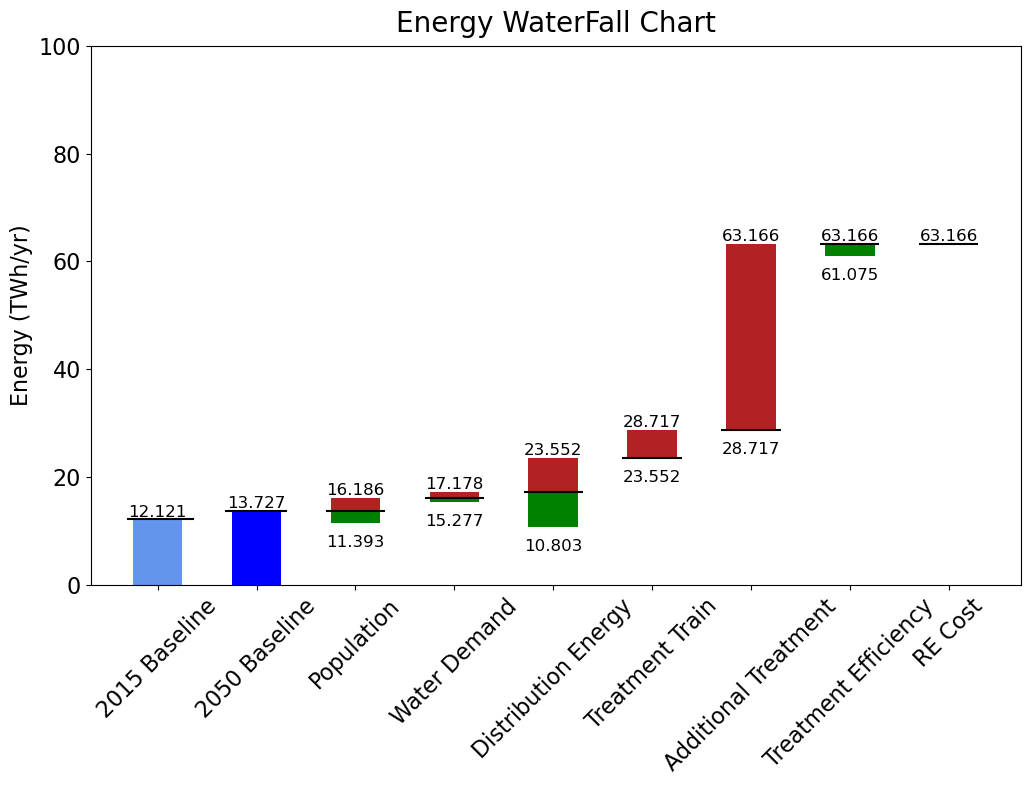

In [86]:
# Waterfall Plot
df = pd.read_excel(r'\Users\mhardika\Documents\AMO\2050\analysis_files\sensitivity_analysis.xlsx',sheet_name='waterfall_sensitivity_energy')
fig,ax = plt.subplots(figsize=(12,7))

ax.bar(x=df.index[0], height=df["height_high"][0], bottom=df["bottom"][0], color='cornflowerblue',width=0.5)
ax.bar(x=df.index[1], height=df["height_high"][1], bottom=df["bottom"][1], color='blue',width=0.5)

bars = ax.bar(x=df.index[2::], height=df["height_high"][2::], bottom=df["bottom"][2::], color='firebrick',width=0.5)
ax.bar(x=df.index[2::], height=df["height_low"][2::], bottom=df["bottom"][2::], color='green',width=0.5)
ax.set_xticks(df.index, df["labels"], fontsize=16,rotation = 45)
ax.tick_params(axis='y', labelsize=16)

ax.axhline(y=df["energy_high_value"][0], xmin= 0.075-0.035, xmax= 0.075+0.035, color='black')
ax.axhline(y=df["energy_high_value"][1], xmin= 0.175-0.03, xmax= 0.175+0.035, color='black')

for idx in range(len(df))[2:-1]:
    plt.text(x=df.index[idx], y=df["energy_low_value"][idx]-5,s="{:.3f}".format(df["energy_low_value"][idx]),
            #  s="{:,} $".format(df["Vals"][idx] if df["Vals"][idx]!=0 else df["Cumulative"][idx]),
             ha="center", va="bottom", fontdict=dict(fontsize=12))
    
for idx in range(len(df)):        
    plt.text(x=df.index[idx], y=df["energy_high_value"][idx],s="{:.3f}".format(df["energy_high_value"][idx]),
            #  s="{:,} $".format(df["Vals"][idx] if df["Vals"][idx]!=0 else df["Cumulative"][idx]),
             ha="center", va="bottom", fontdict=dict(fontsize=12))


bar_start = np.array([plt.getp(item, 'x') for item in bars])
bar_end = bar_start + 0.55
plt.hlines(df['bottom'][2::], bar_start-0.05, bar_end,color='black')

print([plt.getp(item, 'x') for item in bars])
print([plt.getp(item, 'width') for item in bars])

ax.set_ylabel('Energy (TWh/yr)',fontsize=16)
ax.set_ylim([0,100])
plt.title("Energy WaterFall Chart", loc="center", pad=10, fontdict=dict(fontsize=20))

[1.75, 2.75, 3.75, 4.75, 5.75, 6.75, 7.75]
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


Text(0.5, 1.0, 'CO$_{2}$ WaterFall Chart')

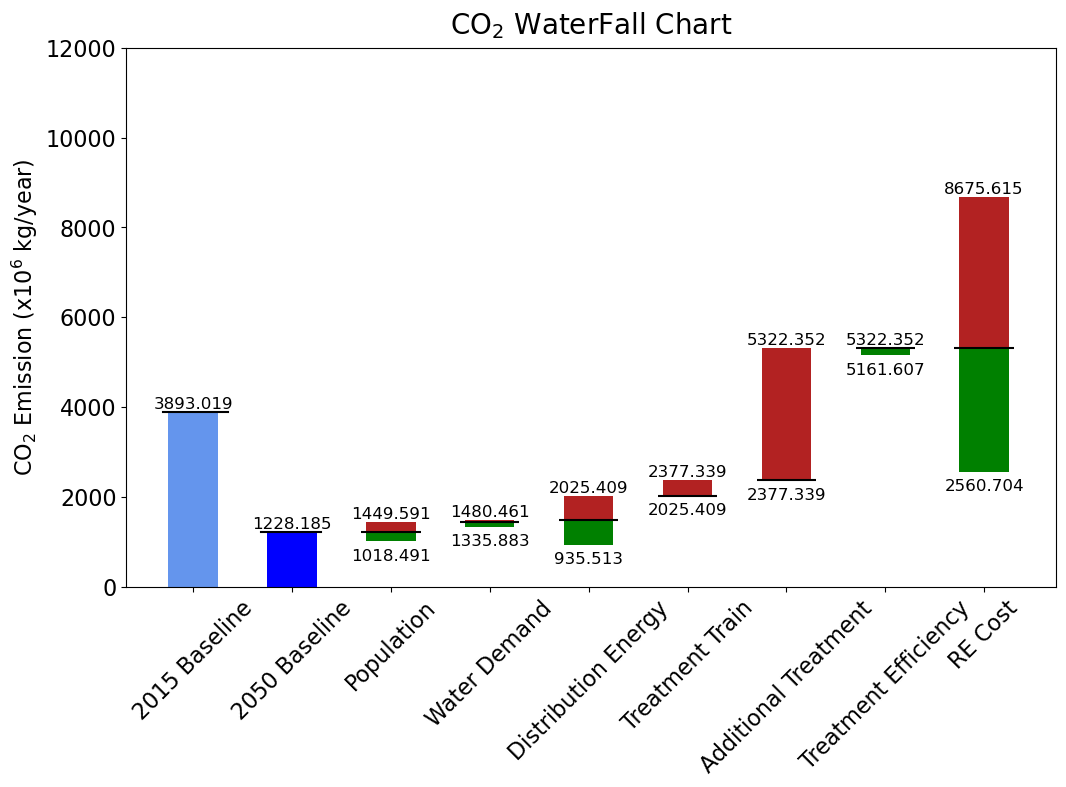

In [87]:
# Waterfall Plot
df = pd.read_excel(r'\Users\mhardika\Documents\AMO\2050\analysis_files\sensitivity_analysis.xlsx',sheet_name='waterfall_sensitivity_co2')
fig,ax = plt.subplots(figsize=(12,7))

ax.bar(x=df.index[0], height=df["height_high"][0], bottom=df["bottom"][0], color='cornflowerblue',width=0.5)
ax.bar(x=df.index[1], height=df["height_high"][1], bottom=df["bottom"][1], color='blue',width=0.5)
# ax1=ax.twinx()
ax.bar(x=df.index[2::], height=df["height_high"][2::], bottom=df["bottom"][2::], color='firebrick',width=0.5)
ax.bar(x=df.index[2::], height=df["height_low"][2::], bottom=df["bottom"][2::], color='green',width=0.5)

ax.axhline(y=df["co2_high_value"][0], xmin= 0.075-0.035, xmax= 0.075+0.035, color='black')
ax.axhline(y=df["co2_high_value"][1], xmin= 0.175-0.03, xmax= 0.175+0.035, color='black')

ax.set_xticks(df.index, df["labels"], fontsize=16,rotation = 45)
ax.tick_params(axis='y', labelsize=16)

for idx in range(len(df)):
    plt.text(x=df.index[idx], y=df["co2_high_value"][idx],s="{:.3f}".format(df["co2_high_value"][idx]),
             ha="center", va="bottom", fontdict=dict(fontsize=12)
            )
    
for idx in range(len(df))[2::]:
    plt.text(x=df.index[idx], y=df["co2_low_value"][idx]-500,s="{:.3f}".format(df["co2_low_value"][idx]),
            #  s="{:,} $".format(df["Vals"][idx] if df["Vals"][idx]!=0 else df["Cumulative"][idx]),
             ha="center", va="bottom", fontdict=dict(fontsize=12))
    
bar_start = np.array([plt.getp(item, 'x') for item in bars])
bar_end = bar_start + 0.55
plt.hlines(df['bottom'][2::], bar_start-0.05, bar_end,color='black')

print([plt.getp(item, 'x') for item in bars])
print([plt.getp(item, 'width') for item in bars])
ax.set_ylabel(r'CO$_{2}$ Emission (x10$^{6}$ kg/year)',fontsize=16)
ax.set_ylim([0,1.2e4])
plt.title(r"CO$_{2}$ WaterFall Chart", loc="center", pad=10, fontdict=dict(fontsize=20))

In [32]:
# Scenario 1 
# Demand low and high (USDA)

scenario_1_low_energy = (sensitivity_results['total_energy(kwh/m3)'])*sensitivity_results['ssp2_wet_demand(m3/day)']*365.25/1000
scenario_1_high_energy = (sensitivity_results['total_energy(kwh/m3)'])*sensitivity_results['ssp2_hot_demand(m3/day)']*365.25/1000

scenario_1_low_co2 = scenario_1_low_energy*[co2_df.loc[state]['2050_medium (kg/MWh)'] for state in sensitivity_results['state'] ]
scenario_1_high_co2 = scenario_1_high_energy*[co2_df.loc[state]['2050_medium (kg/MWh)'] for state in sensitivity_results['state']]

print('Low energy:',scenario_1_low_energy.sum()/1e6)
print('High energy:',scenario_1_high_energy.sum()/1e6)

print('Low CO2:',scenario_1_low_co2.sum()/1e6)
print('High CO2:',scenario_1_high_co2.sum()/1e6)

Low energy: 12.972975454696249
High energy: 14.550383518931184
Low CO2: 1133.7683741952444
High CO2: 1253.6489822856927


In [33]:
# Scenario 2
# Population projection low and high

scenario_2_low_energy = (sensitivity_results['total_energy(kwh/m3)'])*sensitivity_results['ssp3_norm_demand(m3/day)']*365.25/1000
scenario_2_high_energy = (sensitivity_results['total_energy(kwh/m3)'])*sensitivity_results['ssp5_norm_demand(m3/day)']*365.25/1000

scenario_2_low_co2 = scenario_2_low_energy*[co2_df.loc[state]['2050_medium (kg/MWh)'] for state in sensitivity_results['state'] ]
scenario_2_high_co2 = scenario_2_high_energy*[co2_df.loc[state]['2050_medium (kg/MWh)'] for state in sensitivity_results['state']]

print('Low energy:',scenario_2_low_energy.sum()/1e6)
print('High energy:',scenario_2_high_energy.sum()/1e6)

print('Low CO2:',scenario_2_low_co2.sum()/1e6)
print('High CO2:',scenario_2_high_co2.sum()/1e6)

Low energy: 11.393272582724705
High energy: 16.186278984599834
Low CO2: 1018.4909079807425
High CO2: 1449.5905801870936


Text(0, 0.5, 'Energy (TWh/yr)')

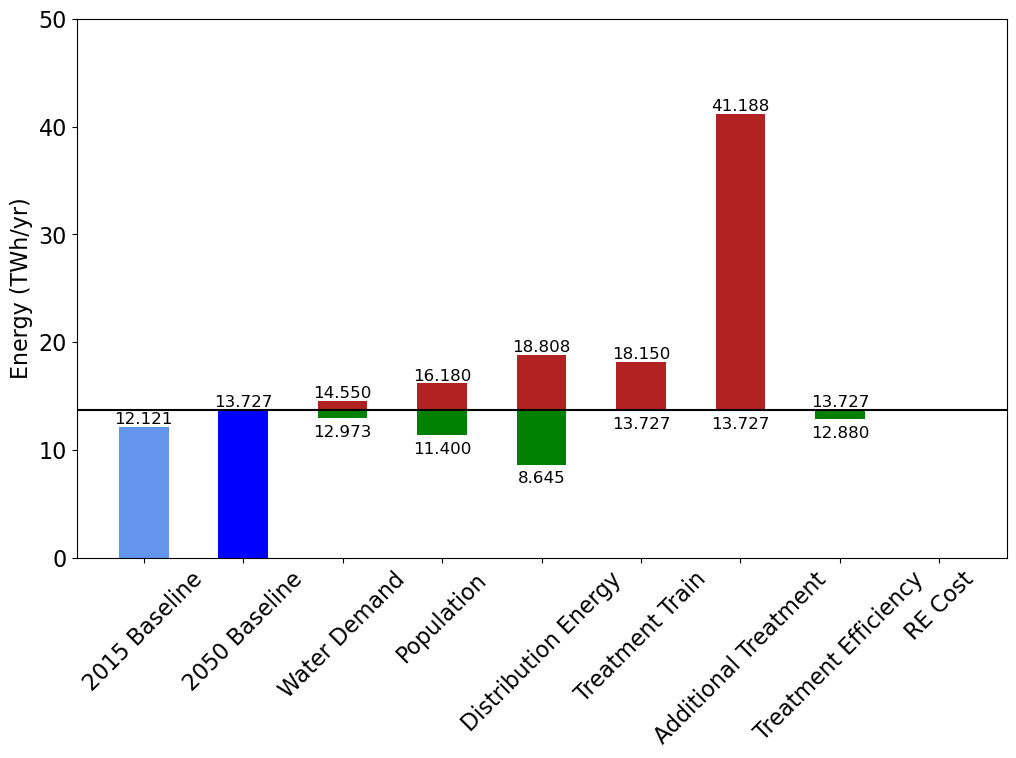

In [10]:
# Sensitivity one at a time
df = pd.read_excel(r'\Users\mhardika\Documents\AMO\2050\analysis_files\sensitivity_analysis.xlsx',sheet_name='sensitivity_analysis')
fig,ax = plt.subplots(figsize=(12,7))

ax.bar(x=df.index[0], height=df["energy_mean(twh/yr)"][0], color='cornflowerblue',width=0.5)
ax.bar(x=df.index[1], height=df["energy_mean(twh/yr)"][1], color='blue',width=0.5)

ax.bar(x=df.index[2::], height= df["energy_high"][2::]- df["energy_mean(twh/yr)"][1], bottom=df["energy_mean(twh/yr)"][1], color='firebrick',width=0.5)
ax.bar(x=df.index[2::], height=df["energy_low"][2::]-df["energy_mean(twh/yr)"][1], bottom=df["energy_mean(twh/yr)"][1], color='green',width=0.5)

ax.set_xticks(df.index, df["parameter"], fontsize=16,rotation = 45)
ax.tick_params(axis='y', labelsize=16)
ax.set_ylim([0,50])

for idx in range(len(df))[2:-1]:
    plt.text(x=df.index[idx], y=df["energy_low"][idx]-2,s="{:.3f}".format(df["energy_low"][idx]),
            #  s="{:,} $".format(df["Vals"][idx] if df["Vals"][idx]!=0 else df["Cumulative"][idx]),
             ha="center", va="bottom", fontdict=dict(fontsize=12))
    
for idx in range(len(df))[2:-1]:        
    plt.text(x=df.index[idx], y=df["energy_high"][idx],s="{:.3f}".format(df["energy_high"][idx]),
            #  s="{:,} $".format(df["Vals"][idx] if df["Vals"][idx]!=0 else df["Cumulative"][idx]),
             ha="center", va="bottom", fontdict=dict(fontsize=12))

plt.text(x=df.index[0], y=df["energy_mean(twh/yr)"][0],s="{:.3f}".format(df["energy_mean(twh/yr)"][0]),
            #  s="{:,} $".format(df["Vals"][idx] if df["Vals"][idx]!=0 else df["Cumulative"][idx]),
             ha="center", va="bottom", fontdict=dict(fontsize=12))    

plt.text(x=df.index[1], y=df["energy_mean(twh/yr)"][idx],s="{:.3f}".format(df["energy_mean(twh/yr)"][idx]),
            #  s="{:,} $".format(df["Vals"][idx] if df["Vals"][idx]!=0 else df["Cumulative"][idx]),
             ha="center", va="bottom", fontdict=dict(fontsize=12))
            
ax.axhline(y=df["energy_mean(twh/yr)"][1], color='black')

ax.set_ylabel('Energy (TWh/yr)',fontsize=16)

Text(0, 0.5, 'CO$_{2}$ Emission (x10$^{6}$ kg/year)')

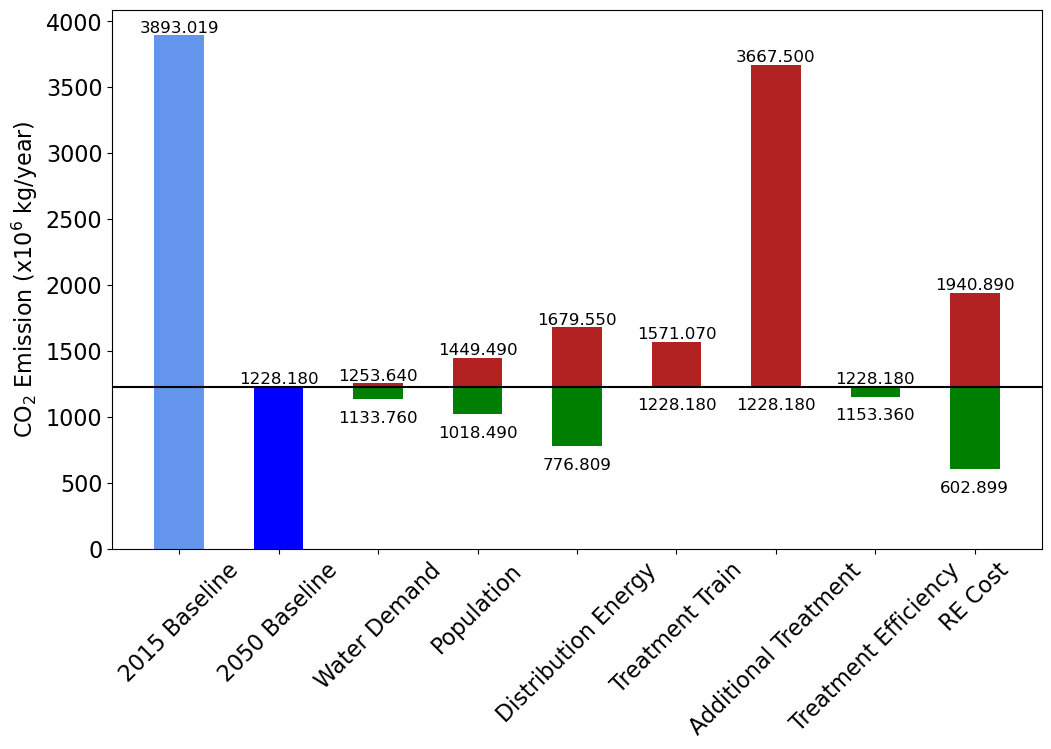

In [11]:
# Sensitivity one at a time
df = pd.read_excel(r'\Users\mhardika\Documents\AMO\2050\analysis_files\sensitivity_analysis.xlsx',sheet_name='sensitivity_analysis')
fig,ax = plt.subplots(figsize=(12,7))

ax.bar(x=df.index[0], height=df["co2_mean(1e6kg/yr)"][0], color='cornflowerblue',width=0.5)
ax.bar(x=df.index[1], height=df["co2_mean(1e6kg/yr)"][1], color='blue',width=0.5)

ax.bar(x=df.index[2::], height= df["co2_high"][2::]- df["co2_mean(1e6kg/yr)"][1], bottom=df["co2_mean(1e6kg/yr)"][1], color='firebrick',width=0.5)
ax.bar(x=df.index[2::], height=df["co2_low"][2::]-df["co2_mean(1e6kg/yr)"][1], bottom=df["co2_mean(1e6kg/yr)"][1], color='green',width=0.5)

ax.set_xticks(df.index, df["parameter"], fontsize=16,rotation = 45)
ax.tick_params(axis='y', labelsize=16)
# ax.set_ylim([0,50])

for idx in range(len(df))[2::]:
    plt.text(x=df.index[idx], y=df["co2_low"][idx]-200,s="{:.3f}".format(df["co2_low"][idx]),
            #  s="{:,} $".format(df["Vals"][idx] if df["Vals"][idx]!=0 else df["Cumulative"][idx]),
             ha="center", va="bottom", fontdict=dict(fontsize=12))
    
for idx in range(len(df))[2::]:        
    plt.text(x=df.index[idx], y=df["co2_high"][idx],s="{:.3f}".format(df["co2_high"][idx]),
            #  s="{:,} $".format(df["Vals"][idx] if df["Vals"][idx]!=0 else df["Cumulative"][idx]),
             ha="center", va="bottom", fontdict=dict(fontsize=12))

plt.text(x=df.index[0], y=df["co2_mean(1e6kg/yr)"][0],s="{:.3f}".format(df["co2_mean(1e6kg/yr)"][0]),
            #  s="{:,} $".format(df["Vals"][idx] if df["Vals"][idx]!=0 else df["Cumulative"][idx]),
             ha="center", va="bottom", fontdict=dict(fontsize=12)) 
    
plt.text(x=df.index[1], y=df["co2_mean(1e6kg/yr)"][1],s="{:.3f}".format(df["co2_mean(1e6kg/yr)"][1]),
            #  s="{:,} $".format(df["Vals"][idx] if df["Vals"][idx]!=0 else df["Cumulative"][idx]),
             ha="center", va="bottom", fontdict=dict(fontsize=12))
            
ax.axhline(y=df["co2_mean(1e6kg/yr)"][1], color='black')

ax.set_ylabel(r'CO$_{2}$ Emission (x10$^{6}$ kg/year)',fontsize=16)